# 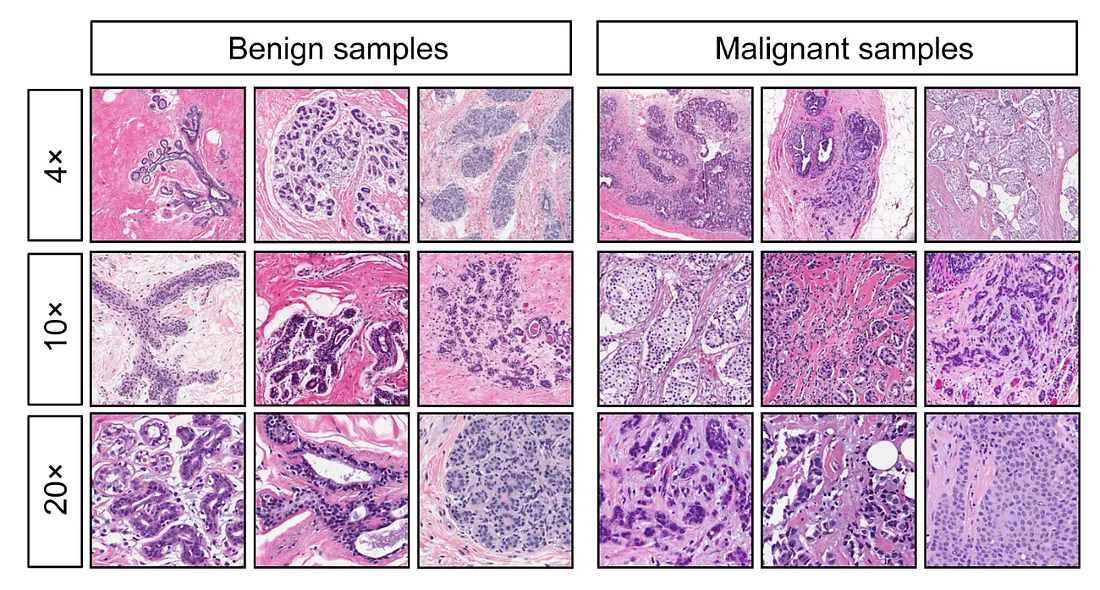

https://miro.medium.com/v2/resize:fit:1100/format:webp/1*pxFCmhRFTighUn88baLcSA.png

# Init.

In [ ]:
# Data manipulation & analysis
import pandas as pd          # For handling tabular data (DataFrame)
import numpy as np           # For numerical operations, arrays, linear algebra

# Visualization
import matplotlib.pyplot as plt  # For creating plots & charts
import seaborn as sns            # For advanced and prettier statistical plots

# Dataset & ML utilities
from sklearn.datasets import load_breast_cancer   # To load the breast cancer dataset
from sklearn.decomposition import PCA             # PCA (Principal Component Analysis) implementation
from sklearn.preprocessing import StandardScaler  # For feature standardization before PCA

# Warning management
import warnings
warnings.filterwarnings("ignore")  # To suppress warning messages for cleaner output


# Data Prep.

In [ ]:
# We use the built-in Breast Cancer dataset from sklearn.
# It contains information about breast tumor cells (numerical features)
# and the target (malignant = cancerous, benign = non-cancerous).
data_loader = load_breast_cancer(as_frame=True)  # 'as_frame=True' gives us a pandas DataFrame
data_loader

In [ ]:
# The 'frame' combines features + target into one DataFrame for easier handling.
data = data_loader.frame
data

# EDA (Simple)

In [ ]:
# Check how many samples we have for each target class
# (0 = malignant, 1 = benign) from metadata
data.target.value_counts()

In [ ]:
# Make the target labels easier to understand (replace 0/1 with words)
target_meaning = {
    0: "malignant",
    1: "benign",
}

# Show class distribution as a bar chart
data.target.replace(target_meaning).value_counts().plot(kind="bar", rot=0, title="class count");

In [ ]:
# Get summary statistics (mean, std, min, max, quartiles) for each feature
data.describe()

# Prep

In [ ]:
# Select all feature columns except the target
features = data.columns[:-1]
features

# Modeling

In [ ]:
# Initialize PCA to reduce data into 2 components
# random_state for reproducibility
pca = PCA(n_components=2, random_state=42)
pca

In [ ]:
# Fit PCA on the features to learn new axes (principal components)
pca.fit(data[features])

# Check how much variance is explained by each component
# (e.g., PC1 might explain 44%, PC2 about 19%)
pca.explained_variance_ratio_

# Evaluation

In [ ]:
# Create a new DataFrame to store PCA results
data_pca = data[["target"]].copy()

# Add human-readable target meaning (benign / malignant)
data_pca["target_meaning"] = data_pca.target.replace(target_meaning)

# Add the first principal component values for each sample
data_pca["component_1"] = pca.transform(data[features])[:,0]

# Add the second principal component values for each sample
data_pca["component_2"] = pca.transform(data[features])[:,1]

# Check the transformed dataset (target + 2 components)
data_pca

In [ ]:
# Plot PCA results: 2D scatterplot of the reduced data
# Hue colors the points by target meaning (benign/malignant)
sns.scatterplot(
    data_pca,
    x="component_1",
    y="component_2",
    hue="target_meaning"
)

# Time Comparation

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ==============================
# Compare model training time & accuracy:
# 1. Using ALL features
# 2. Using PCA (2 components)
# ==============================

# Prepare X and y
X_full = data[features]           # all original features
y = data["target"]

# Train-test split (to evaluate accuracy properly)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

X_pca = data_pca[["component_1", "component_2"]]   # reduced features
X_train_pca, X_test_pca, _, _ = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)

# --- Training with ALL features ---
start = time.time()
lr.fit(X_train_full, y_train)
train_time_full = time.time() - start
acc_full = accuracy_score(y_test, lr.predict(X_test_full))

# --- Training with PCA (2 components) ---
start = time.time()
lr.fit(X_train_pca, y_train)
train_time_pca = time.time() - start
acc_pca = accuracy_score(y_test, lr.predict(X_test_pca))

# --- Results ---
print("=== Model Comparison ===")
print(f"All features -> Time: {train_time_full:.5f}s | Accuracy: {acc_full:.4f}")
print(f"PCA (2 comp) -> Time: {train_time_pca:.5f}s | Accuracy: {acc_pca:.4f}")

# --- Speed improvement ---
speed_improvement = train_time_full / train_time_pca
print(f"\n✅ PCA training is ~{speed_improvement:.2f}x faster than using all features.")


# Other Exploration

In [ ]:
# Initialize PCA to reduce data into 2 components
# random_state for reproducibility
pca = PCA(n_components=12, random_state=42)

# Fit PCA on the features to learn new axes (principal components)
pca.fit(data[features])

# Check how much variance is explained by each component
# (e.g., PC1 might explain 44%, PC2 about 19%)
pca.explained_variance_ratio_

## Scree Plot with cumulative variance

In [ ]:
explained_var = pca.explained_variance_ratio_ * 100
print(explained_var)

cumulative_var = np.cumsum(explained_var)
print(cumulative_var)

components = np.arange(1, len(explained_var) + 1)
print(components)


In [ ]:
plt.figure(figsize=(8,6))
bars = plt.bar(components, explained_var, alpha=0.8, color="steelblue")
plt.plot(components, explained_var, 'o-', color="black", label="Individual variance")
plt.plot(components, cumulative_var, 's--', color="red", label="Cumulative variance")

# Annotate values
for i, val in enumerate(explained_var):
    plt.text(components[i], val + 0.5, f"{val:.1f}%", ha="center", fontsize=9)

plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot with Cumulative Variance")
plt.xticks(components)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Loadings heatmap

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print(loadings)

plt.figure(figsize=(8,6))
plt.imshow(loadings, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Loading strength")
plt.xticks(range(len(pca.components_)), [f"PC{i+1}" for i in range(len(pca.components_))])
plt.yticks(range(len(features)), features)
plt.title("PCA Loadings (feature contribution to PCs)")
plt.show()